___
# Agenda
 - Numerical Optimization Techniques
  - Types of Optimization
  - Programming the Optimization
 - **Whirlwind Lecture Alert**
  - Entire classes cover these concepts in expanded form
  - But you are smart enough to get them in one lecture!
    - Because science!
    
___

# Last Time

|Description| Equations, Derivations, Hessian Calculations, and Miscellaneous|
|-----------|--------|
| Sigmoid Definition | $$ p(y^{(i)}=1\text{ | }\mathbf{x}^{(i)},\mathbf{w})=\frac{1}{1+\exp{(-\mathbf{w}^T \mathbf{x}^{(i)}})}$$ |
| Log Likelihood | $$ l(\mathbf{w}) = \sum_i \left( y^{(i)} \ln [g(\mathbf{w}^T \mathbf{x}^{(i)})] + (1-y^{(i)}) (\ln [1 - g(\mathbf{w}^T \mathbf{x}^{(i)})])  \right)  $$ |
| Vectorized Gradient | $$gradient =\sum_{i=1}^M (y^{(i)}-g(\mathbf{w}^T\mathbf{x}^{(i)}))\mathbf{x}^{(i)}$$ |
| Regularization | $$ \mathbf{w} \leftarrow \mathbf{w} + \eta \left[\underbrace{\nabla l(\mathbf{w})_{old}}_{\text{old gradient}} - C \cdot 2\mathbf{w} \right]$$|

___

<img src="PDF_slides/mark_scooter.png"  width="300">


# More Advanced  Optimization for Machine Learning
From previous notebooks, we know that the logistic regression update equation is given by:

$$ \underbrace{w_j}_{\text{new value}} \leftarrow \underbrace{w_j}_{\text{old value}} + \eta \underbrace{\left[\left(\sum_{i=1}^M (y^{(i)}-g(\mathbf{w}^T\mathbf{x}^{(i)}))x^{(i)}_j\right) - C \cdot 2w_j \right]}_{\nabla l(w)}$$

Which can be made into more generic notation by denoting the objective function as $l(\mathbf{w})$ and the gradient calculation as $\nabla$:
$$ \mathbf{w} \leftarrow \mathbf{w} + \eta \nabla l(\mathbf{w})$$

<img src="PDF_slides/batch.gif"  width="400">

One problem is that we still need to set the value of $\eta$, which can drastically change the performance of the optimization algorithm. If $\eta$ is too large, the algorithm might be unstable. If $\eta$ is too small, it might take a long time (i.e., many iterations) to converge.
$$ \mathbf{w} \leftarrow \mathbf{w} + \underbrace{\eta}_{\text{best step?}} \nabla l(\mathbf{w}) $$

We can solve this issue by performing a line search for the best value of $\eta$ along the direction of the gradient, as denoted by:

$$ \eta \leftarrow \arg\max_\eta \underbrace{\sum_{i=1}^M (y^{(i)}-g(\mathbf{w}^T\mathbf{x}^{(i)}))^2 -C\cdot\sum_j w_j^2}_{\nabla l(\mathbf{w})} $$

<img src="PDF_slides/line_search.gif"  width="400">

# Optimizing Logistic Regression via Line Search

In [ ]:
from sklearn.datasets import load_iris
import numpy as np
from sklearn.metrics import accuracy_score
from scipy.special import expit

ds = load_iris()
X = ds.data
y = (ds.target>1).astype(np.int) # make problem binary

In [ ]:
%%time
# from last time, our logistic regression algorithm is given by (including everything we previously had):
class BinaryLogisticRegression:
    def __init__(self, eta, iterations=20, C=0.001):
        self.eta = eta
        self.iters = iterations
        self.C = C
        # internally we will store the weights as self.w_ to keep with sklearn conventions
        
    def __str__(self):
        if(hasattr(self,'w_')):
            return 'Binary Logistic Regression Object with coefficients:\n'+ str(self.w_) # is we have trained the object
        else:
            return 'Untrained Binary Logistic Regression Object'
        
    # convenience, private:
    @staticmethod
    def _add_bias(X):
        return np.hstack((np.ones((X.shape[0],1)),X)) # add bias term
    
    @staticmethod
    def _sigmoid(theta):
        # increase stability, redefine sigmoid operation
        return expit(theta) #1/(1+np.exp(-theta))
    
    # vectorized gradient calculation with regularization using L2 Norm
    def _get_gradient(self,X,y):
        ydiff = y-self.predict_proba(X,add_bias=False).ravel() # get y difference
        gradient = np.mean(X * ydiff[:,np.newaxis], axis=0) # make ydiff a column vector and multiply through
        
        gradient = gradient.reshape(self.w_.shape)
        gradient[1:] += -2 * self.w_[1:] * self.C
        
        return gradient
    
    # public:
    def predict_proba(self,X,add_bias=True):
        # add bias term if requested
        Xb = self._add_bias(X) if add_bias else X
        return self._sigmoid(Xb @ self.w_) # return the probability y=1
    
    def predict(self,X):
        return (self.predict_proba(X)>0.5) #return the actual prediction
    
    
    def fit(self, X, y):
        Xb = self._add_bias(X) # add bias term
        num_samples, num_features = Xb.shape
        
        self.w_ = np.zeros((num_features,1)) # init weight vector to zeros
        
        # for as many as the max iterations
        for _ in range(self.iters):
            gradient = self._get_gradient(Xb,y)
            self.w_ += gradient*self.eta # multiply by learning rate 
            # add bacause maximizing 

blr = BinaryLogisticRegression(eta=0.1,iterations=500,C=0.001)

blr.fit(X,y)
print(blr)

yhat = blr.predict(X)
print('Accuracy of: ',accuracy_score(y,yhat))

In [4]:
%%time
# and we can update this to use a line search along the gradient like this:
from scipy.optimize import minimize_scalar
import copy
class LineSearchLogisticRegression(BinaryLogisticRegression):
    
    # define custom line search for problem
    
    @staticmethod
    def objective_function(eta,X,y,w,grad,C):
        wnew = w - grad*eta
        g = expit(X @ wnew)
        return -np.sum(np.log(g[y==1]))-np.sum(np.log(1-g[y==0])) + C*sum(wnew**2)
    
        
    def fit(self, X, y):
        Xb = self._add_bias(X) # add bias term
        num_samples, num_features = Xb.shape
        
        self.w_ = np.zeros((num_features,1)) # init weight vector to zeros
        
        # for as many as the max iterations
        for _ in range(self.iters):
            gradient = -self._get_gradient(Xb,y)
            # minimization inopposite direction
            
            # do line search in gradient direction, using scipy function
            opts = {'maxiter':self.iters/50} # unclear exactly what this should be
            res = minimize_scalar(self.objective_function, # objective function to optimize
                                  bounds=(self.eta/1000,self.eta*10), #bounds to optimize
                                  args=(Xb,y,self.w_,gradient,self.C), # additional argument for objective function
                                  method='bounded', # bounded optimization for speed
                                  options=opts) # set max iterations
            
            eta = res.x # get optimal learning rate
            self.w_ -= gradient*eta # set new function values
            # subtract to minimize
                
            

lslr = LineSearchLogisticRegression(eta=0.01,iterations=40, C=0.001)

lslr.fit(X,y)

yhat = lslr.predict(X)
print(lslr)
print('Accuracy of: ',accuracy_score(y,yhat))         

Binary Logistic Regression Object with coefficients:
[[-0.12616889]
 [-0.29791217]
 [-0.37876886]
 [ 0.51370512]
 [ 0.32218262]]
Accuracy of:  0.9733333333333334
CPU times: user 17.2 ms, sys: 3.45 ms, total: 20.7 ms
Wall time: 19.3 ms


This performs well, but was not too much faster than previously (this is because $\eta$ was chosen well in the initial example). 
___

# Self Test
<img src="PDF_slides/self_test_multiplies.png"  width="400">
_____

# Stochastic Gradient Descent
Sometimes the gradient calcualtion is too computational:
$$ \mathbf{w} \leftarrow \mathbf{w} + \eta\left( \sum_{i=1}^M (y^{(i)}-g(\mathbf{w}^T\mathbf{x}^{(i)}))\mathbf{x}^{(i)} -2C\cdot \mathbf{w}\right) $$

Instead, we can approximate the gradient using one instance, this is called stochastic gradient descent (SGD) because the steps can appear somewhat random.
$$ \mathbf{w} \leftarrow \mathbf{w} + \eta \underbrace{\left((y^{(i)}-g(\mathbf{w}^T\mathbf{x}^{(i)}))\mathbf{x}^{(i)}-2C\cdot \mathbf{w}\right)}_{\text{approx. gradient}} \text{,   where   } i\in M$$

<img src="PDF_slides/SGD.gif"  width="400">

Let's code up the SGD example.

In [12]:
%%time
class StochasticLogisticRegression(BinaryLogisticRegression):
    # stochastic gradient calculation 
    def _get_gradient(self,X,y):
        idx = int(np.random.rand()*len(y)) # grab random instance
        ydiff = y[idx]-self.predict_proba(X[idx],add_bias=False) # get y difference (now scalar)
        gradient = X[idx] * ydiff[:,np.newaxis] # make ydiff a column vector and multiply through
        
        gradient = gradient.reshape(self.w_.shape)
        gradient[1:] += -2 * self.w_[1:] * self.C
        
        return gradient
    
    
slr = StochasticLogisticRegression(0.05,500, C=0.001) # take a lot more steps!!

slr.fit(X,y)

yhat = slr.predict(X)
print(slr)
print('Accuracy of: ',accuracy_score(y,yhat))      

Binary Logistic Regression Object with coefficients:
[[-0.55807207]
 [-1.14734635]
 [-1.30229895]
 [ 2.00012099]
 [ 1.38896833]]
Accuracy of:  0.9333333333333333
CPU times: user 18.9 ms, sys: 8.78 ms, total: 27.7 ms
Wall time: 22 ms


___

<img src="PDF_slides/BtJXjJcCAAE7QOB.jpg"  width="300">



# Optimizing with Second Order Derivatives
First, let's look at the one dimensional case when we have a function $l(w)$ where w is a scalar. The optimal value of w is given by:

$$ w \leftarrow w - \underbrace{[\frac{\partial^2}{\partial w}l(w)]^{-1}}_{\text{inverse 2nd deriv}}\underbrace{\frac{\partial}{\partial w}l(w)}_{\text{derivative}}  $$

Note that if $l(w)$ is a quadrativ function, this solution converges in a single step!


|Aside: an example with the second derivative:|
|------------------------------------------------------------------------|
|Say $l(w)=2w^2+4w+5$, and we want to minimize the function. We have that:
|$$\frac{\partial}{\partial w}l(w)=4w+4$$|
| $$\frac{\partial^2}{\partial w}l(w)=4$$|
|Therefore, if we choose $w_{start}=0$, we have:|
|$$\frac{\partial}{\partial w}l(0)=4$$  |
|$$\frac{\partial^2}{\partial w}l(0)=4$$ |
|So the update becomes|
|$$w \leftarrow w_{start} - \frac{1}{4}4 = -1$$|
|The solution is found in one step. This works for any initial value of $w_{start}$. Let's verify that the solution worked graphically.|

Text(-1, 2.5, '$\\leftarrow$found minimum')

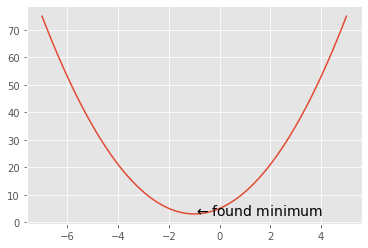

In [13]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

w = np.linspace(-7,5,100)
l = 2*w**2+4*w+5
plt.plot(w,l)
plt.text(-1,2.5,'$\leftarrow$found minimum',fontsize=14)

___

# Newton's Update Method
<img src="PDF_slides/newton.png"  width="600">

But how do we translate this over to objective funtions with more than one variable? We need a second derivative of a multivariate equation... enter, the hessian. Our new update is defined by Newton's method:

$$ w \leftarrow w - \underbrace{[\frac{\partial^2}{\partial w}l(w)]^{-1}}_{\text{inverse 2nd deriv}}\underbrace{\frac{\partial}{\partial w}l(w)}_{\text{derivative}}  $$

to

$$ \mathbf{w} \leftarrow \mathbf{w} + \eta \cdot \underbrace{\mathbf{H}[l(\mathbf{w})]^{-1}}_{\text{inverse Hessian}}\cdot\underbrace{\nabla l(\mathbf{w})}_{\text{gradient}}$$

where the Hessian is defined as follows for any multivariate equation $l(\mathbf{w})$:
$$ \nabla^2 l(\mathbf{w}) = \mathbf{H}[l(\mathbf{w})]   $$

$$  \mathbf{H}[l(\mathbf{w})] =  \begin{bmatrix}
        \frac{\partial^2}{\partial w_1}l(\mathbf{w}) &  \frac{\partial}{\partial w_1}\frac{\partial}{\partial w_2}l(\mathbf{w}) & \ldots     & \frac{\partial}{\partial w_1}\frac{\partial}{\partial w_N}l(\mathbf{w})  \\
        \frac{\partial}{\partial w_2}\frac{\partial}{\partial w_1}l(\mathbf{w})  & \frac{\partial^2}{\partial w_2}l(\mathbf{w}) &  \ldots     & \frac{\partial}{\partial w_2}\frac{\partial}{\partial w_N}l(\mathbf{w})  \\
        &  \vdots &\\
        \frac{\partial}{\partial w_N}\frac{\partial}{\partial w_1}l(\mathbf{w})  & \frac{\partial}{\partial w_N}\frac{\partial}{\partial w_2}l(\mathbf{w}) &  \ldots     & \frac{\partial^2}{\partial w_N}l(\mathbf{w}) \\
     \end{bmatrix}
$$



____
For logistic regression:

<img src="PDF_slides/hessian_derive.png"  width="400">

Therefore the Hessian for logistic regression becomes:
$$ \mathbf{H}_{j,k}[l(\mathbf{w})] = -\sum_{i=1}^M g(\mathbf{w}^T\mathbf{x}^{(i)})[1-g(\mathbf{w}^T\mathbf{x}^{(i)})]{x_k}^{(i)}{x_j}^{(i)} + \underbrace{2\cdot C}_{\text{regularization}}  $$

You can see the full derivation of the Hessian in my notes here:
- https://raw.githubusercontent.com/eclarson/MachineLearningNotebooks/master/PDF_Slides/HessianCalculation.pdf

$$ \mathbf{H}[l(\mathbf{w})] =  \mathbf{X}^T \cdot \text{diag}\left[g(\mathbf{X}\cdot\mathbf{w})*(1-g(\mathbf{X}\cdot\mathbf{w}))\right]\cdot \mathbf{X} -2C$$

Now we can place the Hessian derivation into the Newton Update Equation, like this:

$$ \mathbf{w} \leftarrow \mathbf{w} + \eta \cdot \underbrace{\mathbf{H}[l(\mathbf{w})]^{-1}}_{\text{inverse Hessian}}\cdot\underbrace{\nabla l(\mathbf{w})}_{\text{gradient}}$$

$$ \mathbf{w} \leftarrow \mathbf{w} + \eta \cdot \underbrace{\left[\mathbf{X}^T \cdot \text{diag}\left[g(\mathbf{X}\cdot\mathbf{w})(1-g(\mathbf{X}\cdot\mathbf{w}))\right] \cdot \mathbf{X} -2C \right]^{-1} }_{\text{inverse Hessian}} \cdot \underbrace{\mathbf{X}*y_{diff}}_{\text{gradient}}$$

So let's code this up using numpy:

In [24]:
%%time
from numpy.linalg import pinv
class HessianBinaryLogisticRegression(BinaryLogisticRegression):
    # just overwrite gradient function
    def _get_gradient(self,X,y):
        g = self.predict_proba(X,add_bias=False).ravel() # get sigmoid value for all classes
        hessian = X.T @ np.diag(g*(1-g)) @ X - 2 * self.C # calculate the hessian

        ydiff = y-g # get y difference
        gradient = np.sum(X * ydiff[:,np.newaxis], axis=0) # make ydiff a column vector and multiply through
        gradient = gradient.reshape(self.w_.shape)
        gradient[1:] += -2 * self.w_[1:] * self.C
        
        return pinv(hessian) @ gradient
       
hlr = HessianBinaryLogisticRegression(eta=1.0,iterations=1,C=0.001) # note that we need only a few iterations here

hlr.fit(X,y)
yhat = hlr.predict(X)
print(hlr)
print('Accuracy of: ',accuracy_score(y,yhat))

Binary Logistic Regression Object with coefficients:
[[-4.75308496]
 [-0.17462172]
 [ 0.79365037]
 [ 0.0172447 ]
 [ 2.18414582]]
Accuracy of:  0.9266666666666666
CPU times: user 2.06 ms, sys: 1.58 ms, total: 3.64 ms
Wall time: 2.77 ms


___
# Problems With the Hessian
Quadratic isn’t always a great assumption:
 - highly dependent on starting point
  - jumps can get really random!
 - near saddle points, inverse hessian unstable
 - hessian not always invertible… or invertible with correct numerical precision
 
The Hessian can sometimes be ill formed for these problems and can also be highly computational. Thus, we need to approximate the Hessian, and also use some heuristics (like momentum) to better control the steps we make and directions we use.  

## Quasi-Newton Methods
In general:
 - approximate the Hessian with something numerically sound and efficiently invertible 
 - back off to gradient descent when the approximate hessian is not stable
 - use momentum to update approximate hessian
 - A popular approach: use Broyden-Fletcher-Goldfarb-Shanno (BFGS)

### BFGS
One of the most popular quasi-Newton methods is known as Broyden-Fletcher-Goldfarb-Shanno (BFGS). We won't explicitly program the BFGS algorithm--instead we can take advantage of scipy's calculations to do it for us. For using this algorithm, we need to define the objective function and the gradient explicitly for another program to calculate. 

- https://en.wikipedia.org/wiki/Broyden–Fletcher–Goldfarb–Shanno_algorithm 

Essentially, we want to update the Hessian with an approximation that is easily invertible and based on stable gradient calculations. We can define the approximate Hessian for each iteration, $\mathbf{H}_k$. 

|Description| Equations, Derivations, Hessian Calculations, and Miscellaneous |
|-----------|--------|
|1. Initial Approx. Hessian for $k=0$ is identity matrix| $$\mathbf{H}_0=\mathbf{I}$$|
|2. Find update direction, $p_k$ | $$ p_k = -\mathbf{H}_k^{-1} \nabla l(w_k) $$| 
|3. Update $w_k$|$$w_{k+1}\leftarrow w_k + \eta \cdot p_k $$|
|4. Save scaled direction| $$s_k=\eta \cdot p_k$$ |
|5. Approximate change in derivative | $$v_k = \nabla l(w_{k+1}) - \nabla l(w_k) $$|
|6. Redefine approx Hessian| $$\mathbf{H}_{k+1}=\mathbf{H}_k+\underbrace{\frac{v_k v_k^T}{v_k^T s_k}}_{\text{approx. Hessian}} -\underbrace{\frac{\mathbf{H}_k s_k s_k^T \mathbf{H}_k}{s_k^T \mathbf{H}_k s_k}}_{\text{momentum}} $$ |
|7. Approximate Inverse $\mathbf{H}_{k+1}$| $$ \mathbf{H}_{k+1}^{-1} = \mathbf{H}_{k}^{-1} + \frac{(s_k^T v_k+\mathbf{H}_{k}^{-1})(s_ks_k^T)}{(s_k^T v_k)^2}-\frac{\mathbf{H}_{k}^{-1}v_ks_k^T+s_kv_k^T\mathbf{H}_{k}^{-1}}{s_k^T v_k} $$|
| 8. Repeat starting at step 2| $$ k = k+1 $$| 

Of course, we do not need to program this method because it already exists. We just need to understand the API to get the full functionality. Recall that Logistic regression uses the following objective function:

$$ l(w) = \left(\sum_i y^{(i)} \ln g(x^{(i)}) + (1-y^{(i)})\ln[1-g(x^{(i)})]\right)  - C \cdot \sum_j w_j^2 $$

In [27]:
%%time
# for this, we won't perform our own BFGS implementation 
# (it takes a good deal of code and understanding of the algorithm)
# luckily for us, scipy has its own BFGS implementation:
from scipy.optimize import fmin_bfgs
class BFGSBinaryLogisticRegression(BinaryLogisticRegression):
    
    @staticmethod
    def objective_function(w,X,y,C):
        g = expit(X @ w)
        return -np.sum(np.log(g[y==1]))-np.sum(np.log(1-g[y==0])) + C*sum(w**2) #-np.sum(y*np.log(g)+(1-y)*np.log(1-g))

    @staticmethod
    def objective_gradient(w,X,y,C):
        g = expit(X @ w)
        ydiff = y-g # get y difference
        gradient = np.mean(X * ydiff[:,np.newaxis], axis=0)
        gradient = gradient.reshape(w.shape)
        gradient[1:] += -2 * w[1:] * C
        return -gradient
    
    # just overwrite fit function
    def fit(self, X, y):
        Xb = self._add_bias(X) # add bias term
        num_samples, num_features = Xb.shape
        
        self.w_ = fmin_bfgs(self.objective_function, # what to optimize
                            np.zeros((num_features,1)), # starting point
                            fprime=self.objective_gradient, # gradient function
                            args=(Xb,y,self.C), # extra args for gradient and objective function
                            gtol=1e-03, # stopping criteria for gradient, |v_k|
                            maxiter=self.iters, # stopping criteria iterations
                            disp=False)
        
        self.w_ = self.w_.reshape((num_features,1))
            
bfgslr = BFGSBinaryLogisticRegression(_,2,C=0.001) # note that we need only a few iterations here

bfgslr.fit(X,y)
yhat = bfgslr.predict(X)
print(bfgslr)
print('Accuracy of: ',accuracy_score(y,yhat))

Binary Logistic Regression Object with coefficients:
[[-0.11114639]
 [-0.26762263]
 [-0.37781461]
 [ 0.49330217]
 [ 0.28629542]]
Accuracy of:  0.98
CPU times: user 4.14 ms, sys: 1.84 ms, total: 5.98 ms
Wall time: 4.62 ms


In [ ]:
#str(bfgslr.eta)

### BFGS for Multiclass Logistic Regression
Now let's add BFGS to non-binary classification. As before, we will use one-versus-all.

In [28]:
class MultiClassLogisticRegression:
    def __init__(self, eta, iterations=20, C=0.0001):
        self.eta = eta
        self.iters = iterations
        self.C = C
        self.classifiers_ = []
        # internally we will store the weights as self.w_ to keep with sklearn conventions
    
    def __str__(self):
        if(hasattr(self,'w_')):
            return 'MultiClass Logistic Regression Object with coefficients:\n'+ str(self.w_) # is we have trained the object
        else:
            return 'Untrained MultiClass Logistic Regression Object'
        
    def fit(self,X,y):
        num_samples, num_features = X.shape
        self.unique_ = np.sort(np.unique(y)) # get each unique class value
        num_unique_classes = len(self.unique_)
        self.classifiers_ = []
        for i,yval in enumerate(self.unique_): # for each unique value
            y_binary = y==yval # create a binary problem
            # train the binary classifier for this class
            hblr = BFGSBinaryLogisticRegression(self.eta,self.iters,self.C)
            hblr.fit(X,y_binary)
            #print(accuracy(y_binary,hblr.predict(X)))
            # add the trained classifier to the list
            self.classifiers_.append(hblr)
            
        # save all the weights into one matrix, separate column for each class
        self.w_ = np.hstack([x.w_ for x in self.classifiers_]).T
        
    def predict_proba(self,X):
        probs = []
        for hblr in self.classifiers_:
            probs.append(hblr.predict_proba(X).reshape((len(X),1))) # get probability for each classifier
        
        return np.hstack(probs) # make into single matrix
    
    def predict(self,X):
        return np.argmax(self.predict_proba(X),axis=1) # take argmax along row
    



In [29]:
from sklearn.preprocessing import StandardScaler


ds = load_iris()
X = ds.data

X = StandardScaler().fit(X).transform(X)
y_not_binary = ds.target # note problem is NOT binary anymore, there are three classes!

In [31]:
%%time
lr = MultiClassLogisticRegression(_,iterations=10,C=0.001)
lr.fit(X,y_not_binary)
print(lr)

yhat = lr.predict(X)
print('Accuracy of: ',accuracy_score(y_not_binary,yhat))

MultiClass Logistic Regression Object with coefficients:
[[-2.10666758 -1.37710387  2.12177587 -2.33013903 -2.18114396]
 [-0.86687856  0.2681656  -1.48158254  0.37887989 -0.70883214]
 [-5.54625821  1.14495766  0.17809041  3.19612685  4.55144602]]
Accuracy of:  0.9333333333333333
CPU times: user 11.8 ms, sys: 2.58 ms, total: 14.4 ms
Wall time: 12.6 ms


In [33]:
%%time
# how do we compare now to sklearn?
from sklearn.linear_model import LogisticRegression

lr_sk = LogisticRegression(solver='lbfgs',n_jobs=1) # all params default
# note that sklearn is optimized for using the liblinear library with logistic regression
# ...and its faster than our implementation here

lr_sk.fit(X,y_not_binary) # no need to add bias term, sklearn does it internally!!
print(lr_sk.coef_)
yhat = lr_sk.predict(X)
print('Accuracy of: ',accuracy_score(y_not_binary,yhat))

[[-1.0587411   1.22287507 -1.76441737 -1.63742564]
 [ 0.13008673 -1.26245048  0.79595969 -0.89205903]
 [ 0.13994171 -0.51269087  2.48202553  3.14075251]]
Accuracy of:  0.9466666666666667
CPU times: user 22.6 ms, sys: 2.49 ms, total: 25.1 ms
Wall time: 19.3 ms


In [34]:
%%time
# actually, we aren't quite as good as the lib linear implementation
# how do we compare now to sklearn?
from sklearn.linear_model import LogisticRegression

lr_sk = LogisticRegression(solver='liblinear',n_jobs=1) 

lr_sk.fit(X,y_not_binary) # no need to add bias term, sklearn does it internally!!
print(lr_sk.coef_)
yhat = lr_sk.predict(X)
print('Accuracy of: ',accuracy_score(y_not_binary,yhat))

[[-0.81016631  1.39369878 -1.68738578 -1.51899135]
 [ 0.13037985 -1.2463382   0.78919477 -0.88943988]
 [ 0.01299039 -0.1445346   1.86317337  2.69887272]]
Accuracy of:  0.9266666666666666
CPU times: user 3.39 ms, sys: 1.32 ms, total: 4.71 ms
Wall time: 3.59 ms


Liblinear is a great toolkit for linear modeling (from national Taiwan University) and the paper can be found here:
- https://www.csie.ntu.edu.tw/~cjlin/papers/liblinear.pdf

Actually, this solves a slightly different problem (than maximum likelihood) to make it extremely fast. **If you are a student taking this class for 7000 credit, you will need to slightly alter your method to get the same speed and result as sklearn.**

In [ ]:
%%time
# its still faster! Can we fix that?
from joblib import Parallel, delayed

class ParallelMultiClassLogisticRegression(MultiClassLogisticRegression):
    @staticmethod
    def par_logistic(yval,eta,iters,C,X,y):
        y_binary = y==yval # create a binary problem
        # train the binary classifier for this class
        hblr = BFGSBinaryLogisticRegression(eta,iters,C)
        hblr.fit(X,y_binary)
        return hblr
    
    def fit(self,X,y):
        num_samples, num_features = X.shape
        self.unique_ = np.sort(np.unique(y)) # get each unique class value
        num_unique_classes = len(self.unique_)
        backend = 'threading' # can also try 'multiprocessing'
        
        self.classifiers_ = Parallel(n_jobs=-1,backend=backend)(
            delayed(self.par_logistic)(yval,self.eta,self.iters,self.C,X,y) for yval in self.unique_)
            
        # save all the weights into one matrix, separate column for each class
        self.w_ = np.hstack([x.w_ for x in self.classifiers_]).T
        
plr = ParallelMultiClassLogisticRegression(eta=0.1,iterations=10,C=0.0001)
plr.fit(X,y_not_binary)
print(plr)

yhat = plr.predict(X)
print('Accuracy of: ',accuracy_score(y_not_binary,yhat))

___
Please note that the overhead of parallelization is not worth it for this problem!!

**When would it make sense???**
___
# Next Time: In Class Assignment, SVMs
___
# Next Next Time: Neural Networks
___